# Beer or Wine: the impact of climate change on Bamberg's vineyards
# Research Question
### Can Franconia's wine region now include Bamberg due to warmer weather?
Despite the negative effects of climate change, some wine varietals thrive in warmer climates. For instance, Bamberg, once a wine-producing region, could potentially regain its status due to rising temperatures. We compare the climate of nearby Würzburg, at the heart of the Franconian winemaking region, to Bamberg's which is "officialy" just outside of the Franconian winemaking region.

## Map of Germany's Winemaknig Regions
![Map of Germany's Winemaknig Regions](https://upload.wikimedia.org/wikipedia/commons/8/89/WeinbaugebieteDeutschland.svg)

## Data Sources
We chose to use station data from the Deutscher Wetterdienst (DWD) because it has many direct measures of weather (ex. air temperature 2 meters above ground) and is accurate, easily accessible, and the DWD works to ensure historical data is integrated and well-maintained.

The data we'll be using are the following (more information can be found [here](https://wetterdienst.readthedocs.io/en/latest/data/coverage/dwd/observation/monthly.html)):
- QN_4 - quality level of the data in the following columns
- MO_N - monthly mean of cloud cover
- MO_TT - monthly mean of daily temperature means in 2m height
- MO_TX - monthly mean of daily temperature maxima in 2m height
- MO_TN - monthly mean of daily temperature minima in 2m height
- MO_FK - monthly mean of daily wind speed
- MX_TX - monthly maximum of daily temperature maxima in 2m height
- MX_FX - monthly maximum of daily wind speed
- MX_TN - monthly minimum of daily temperature minima in 2m height
- MO_SD_S - monthly sum of sunshine duration
- QN_6 - quality level of the data in the following columns
- MO_RR - monthly sum of precipitation height
- MX_RS - monthly maximum of daily precipitation height

### Datasource1: Deutscher Wetterdienst (DWD) Station 282 Bamberg
* Metadata URL: https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/monthly/kl/historical/DESCRIPTION_obsgermany_climate_monthly_kl_historical_en.pdf
* Data URL: https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/monthly/kl/historical/monatswerte_KL_00282_18810101_20231231_hist.zip
* Data Type: TXT

This data is from the German weather service DWD at node 282 in Bamberg. We'll be using the air temperature monthly aggregate from 1949 - 2024.

### Datasource2: Deutscher Wetterdienst (DWD) Station 5705 Würzburg
* Metadata URL: https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/monthly/kl/historical/DESCRIPTION_obsgermany_climate_monthly_kl_historical_en.pdf
* Data URL: https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/monthly/kl/historical/monatswerte_KL_05705_18810101_20231231_hist.zip
* Data Type: TXT

This data is from the German weather service DWD at node 5705 in Würzburg. We'll be using the air temperature monthly aggregate from 1949 - 2024.

### Data Source License
The license information can be found in German [here](https://opendata.dwd.de/LIESMICH.txt) and in English [here](https://www.dwd.de/EN/service/legal_notice/legal_notice.html). The weather data is offered under a [Creative Commons 4.0 license](https://creativecommons.org/licenses/by/4.0/). We will fulfill the obligations to name the data source used in a manner which complies with [these guidelines](https://www.dwd.de/EN/service/legal_notice/templates_dwd_as_source.html?nn=450678).

## Data Pipeline
### Overview
We used Python with the urllib.request library for downloading the dataset from the DWD website, the zipfile library to extract the .txt file from the dowloaded ZIP file, and pandas for temporarily storing and transforming the data.

### Transformations
The following transformation steps were applied:
1. Loading the CSV (in .txt form) into pandas converted data types into appropriate values like int64 and float64
2. The "eor" (end of record) column was removed as that's not necessary for our purposes.
3. Missing or invalid data are marked with -999 in the dataset. We replace these with pd.NA (NA values) since we don't want to be able to compare, numerically, valid and invalid data at all.

### Problems
We first attempted to use Jayvee to create the pipeline but ran into issues with formatting. Specifically, it was too difficult to remove (especially varying amounts of) preceding whitespace from a text file which separated values by with a character. This also prevented us from changing the value types from string to integer or decimal. We were also unable to chain multiple transformations, making this issue too time consuming to resolve with Jayvee.

The issue was resolved when we switched to Python using additional libraries.

### Errors and Updates
The DWD has a fixed format for files and data, so we don't expect any deviation from the current format unless DWD standards change.

We do check to see if the file was downloaded, and the data extracted correctly. If not, the process is halted. It's worthy of note that the DWD also has a standardized file naming structure.

The data we are using is updated regularly (at least monthly). No assumptions were made regarding the size of the data we are processing so additional or updated rows should not affect the pipeline negatively. The addition of an entirely new category of data (a new column) would go unused but should not break the pipeline because of how pandas dataframes work.

## Results and Limitations of the Pipeline

In [ ]:
import pandas as pd

from FranconianWeather import download_file
from FranconianWeather import load_txt_from_zip
from FranconianWeather import clean_df
from FranconianWeather import save_to_sqlite

In [ ]:
bamberg = "monatswerte_KL_00282_18810101_20231231_hist.zip"
wuerzburg = "monatswerte_KL_05705_18810101_20231231_hist.zip"

download_file(bamberg)
download_file(wuerzburg)

In [ ]:
# Define the name of the text file inside the zip file
bamberg_data_file = "produkt_klima_monat_18810101_20231231_00282.txt"

# Load the text file into a pandas DataFrame
bamberg_df = load_txt_from_zip(bamberg, bamberg_data_file)

bamberg_df

In [ ]:
wuerzburg_data_file = "produkt_klima_monat_18810101_20231231_05705.txt"

wuerzburg_df = load_txt_from_zip(wuerzburg, wuerzburg_data_file)

wuerzburg_df

In [ ]:
# Combine the dataframes so we can save to a database
combined_df = pd.concat([bamberg_df, wuerzburg_df])

In [ ]:
# Remove eor column and replace missing and invalid values (-999) with pd.NA.
clean_df(combined_df)

combined_df

In [ ]:
# Save the DataFrame to an SQLite database
save_to_sqlite(combined_df, 'franconian-weather')

### Structure and Quality
The data is tabularly structured into means of means and extrema (min. and max.) as well as the maximum of extrema by month.

We chose to combine both weather stations into a single database for easier storage and loading. It is trivial to split the data again by station ID if need be.

Accuracy, completeness, consistency and timeliness is ensured by a trusted institution, the DWD.

The data is relevant for the question at hand. However, a major factor which affects the growth of vineyards is soil nutrients. That information is not present in our data.

### Output Format
The output is formatted as a .sqlite file for long-term storage and wide compatibility. We intend to analyze the data using pandas dataframes.

### Reflection and Potential Issues
We intend to compare these categories or features between the two datasets and see how much overlap there is.

We're conflicted on renaming the columns; on the one hand they are well-defined with precise meanings from DWD but on the other hand one needs to become familiar with this naming convention to work with them effectively.

We're also concerned that we'll run into errors when trying to compare periods with missing data. However, because a comparison is not possible, we'll likely drop the rows (months) of the specific columns (features) which cannot be compared. We're unable to do this during the data pipeline because that would create a poorly structured database (some columns will be missing some months that other columns are not missing).

# Data Analysis
### Method
First we calculate summary statistics and graph the data to better understand it.

Then, we use the station id as a target to see if we can seperate (linearly or non-linearly) the rest of the data. If we clearly seperate the data, there is a substantial difference. If we can't, there isn't.

In [1]:
import pandas as pd
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import os
from sklearn.preprocessing import StandardScaler
import visualizer
import analyzer

current_dir = %pwd
parent_dir = os.path.dirname(current_dir)
db_name = "franconian-weather"
table_name = "\"franconian-weather\"" #hyphen cuasing issues in the next block.
db_location = os.path.join(parent_dir, "data", f"{db_name}.sqlite")

print(db_location)

d:\(D) Google Drive\School\FAU\Classes\'24 SoSe\MADE\MADE\data\franconian-weather.sqlite


In [2]:
# Load the data and take a look
conn = sqlite3.connect(db_location)
df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
conn.close()

print("Shape: ", df.shape)
print(df.info())
df.sample(8)

Shape:  (3416, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3416 entries, 0 to 3415
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   STATIONS_ID        3416 non-null   int64  
 1   DATE               3416 non-null   object 
 2   MESS_DATUM_BEGINN  3416 non-null   object 
 3   MESS_DATUM_ENDE    3416 non-null   object 
 4   QN_4               3320 non-null   float64
 5   MO_N               1743 non-null   float64
 6   MO_TT              1829 non-null   float64
 7   MO_TX              3317 non-null   float64
 8   MO_TN              1821 non-null   float64
 9   MO_FK              1803 non-null   float64
 10  MX_TX              1821 non-null   float64
 11  MX_FX              1240 non-null   float64
 12  MX_TN              1821 non-null   float64
 13  MO_SD_S            1753 non-null   float64
 14  QN_6               1980 non-null   float64
 15  MO_RR              1979 non-null   float64
 16  MX_RS

,STATIONS_ID,DATE,MESS_DATUM_BEGINN,MESS_DATUM_ENDE,QN_4,MO_N,MO_TT,MO_TX,MO_TN,MO_FK,MX_TX,MX_FX,MX_TN,MO_SD_S,QN_6,MO_RR,MX_RS
2356,5705,1934-05-01 00:00:00,1934-05-01,1934-05-31,5.0,NaN,NaN,21.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
302,282,1906-03-01 00:00:00,1906-03-01,1906-03-31,5.0,NaN,NaN,7.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1892,5705,1895-09-01 00:00:00,1895-09-01,1895-09-30,5.0,NaN,NaN,24.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2047,5705,1908-08-01 00:00:00,1908-08-01,1908-08-31,5.0,NaN,NaN,19.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
275,282,1903-12-01 00:00:00,1903-12-01,1903-12-31,5.0,NaN,NaN,1.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1656,282,2019-01-01 00:00:00,2019-01-01,2019-01-31,9.0,6.66,0.88,3.29,-2.18,2.35,8.4,17.4,-12.3,42.0,9.0,46.1,8.8
3291,5705,2013-08-01 00:00:00,2013-08-01,2013-08-31,10.0,4.51,18.84,24.93,13.20,1.84,35.3,NaN,8.1,225.2,9.0,108.9,55.7
2479,5705,1944-08-01 00:00:00,1944-08-01,1944-08-31,5.0,NaN,NaN,29.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We begin to compare the two sets of data by making histograms of various features and visually checking for dissimilarity.

In [3]:
import matplotlib.pyplot as plt

Bamberg_df = analyzer.station_selector(df, 282)
Wuerzburg_df = analyzer.station_selector(df, 5705)

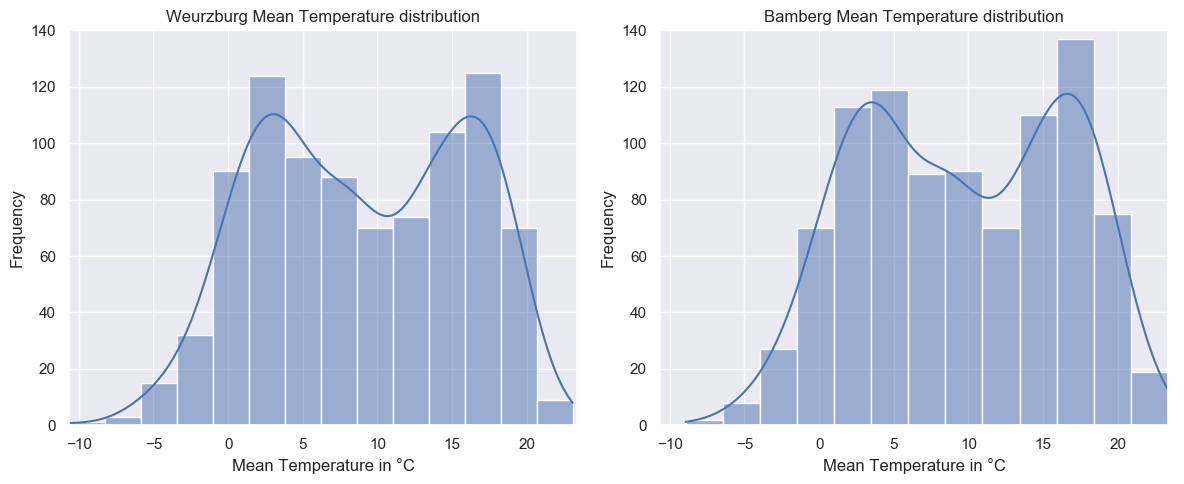

1949-01-01 00:00:00
1946-08-01 00:00:00


<Figure size 640x480 with 0 Axes>

In [4]:
feature_of_interest = 'MO_TT' # Monthly mean temperature

global_xmin = min(Bamberg_df[feature_of_interest].min(),
                  Wuerzburg_df[feature_of_interest].min())
global_xmax = max(Bamberg_df[feature_of_interest].max(),
                  Wuerzburg_df[feature_of_interest].max())

global_ymin = 0
global_ymax = 140

xlim = (global_xmin, global_xmax)
ylim = (global_ymin, global_ymax)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

visualizer.plot_feature_histogram(Bamberg_df, feature_of_interest,
                                  ax=axs[0], xlim=xlim, ylim=ylim)
axs[0].set_title("Weurzburg " + axs[0].get_title())


visualizer.plot_feature_histogram(Wuerzburg_df, feature_of_interest,
                                  ax=axs[1], xlim=xlim, ylim=ylim)
axs[1].set_title("Bamberg " + axs[1].get_title())

plt.tight_layout()
plt.show()

# Check the first date which has a valid value.
print(analyzer.first_date_with_data(Bamberg_df, feature_of_interest))
print(analyzer.first_date_with_data(Wuerzburg_df, feature_of_interest))

plt.clf()

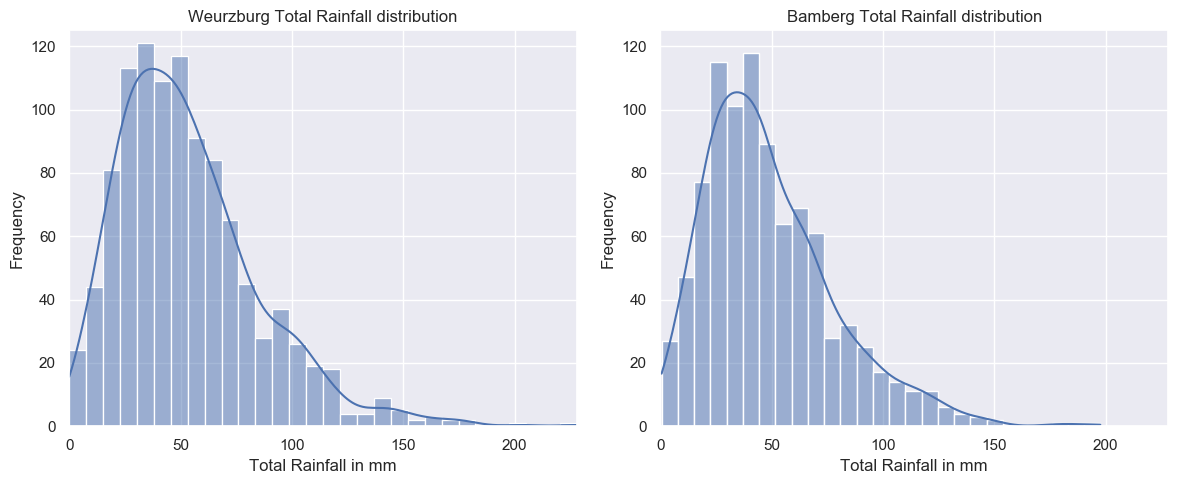

1936-01-01 00:00:00
1947-01-01 00:00:00


<Figure size 640x480 with 0 Axes>

In [5]:
feature_of_interest = 'MO_RR' # Monthly percipitation

global_xmin = min(Bamberg_df[feature_of_interest].min(),
                  Wuerzburg_df[feature_of_interest].min())
global_xmax = max(Bamberg_df[feature_of_interest].max(),
                  Wuerzburg_df[feature_of_interest].max())

global_ymin = 0
global_ymax = 125

xlim = (global_xmin, global_xmax)
ylim = (global_ymin, global_ymax)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

visualizer.plot_feature_histogram(Bamberg_df, feature_of_interest,
                                  ax=axs[0], xlim=xlim, ylim=ylim)
axs[0].set_title("Weurzburg " + axs[0].get_title())


visualizer.plot_feature_histogram(Wuerzburg_df, feature_of_interest,
                                  ax=axs[1], xlim=xlim, ylim=ylim)
axs[1].set_title("Bamberg " + axs[1].get_title())

plt.tight_layout()
plt.show()

# Check the first date which has a valid value.
print(analyzer.first_date_with_data(Bamberg_df, feature_of_interest))
print(analyzer.first_date_with_data(Wuerzburg_df, feature_of_interest))

plt.clf()

Next, we want to check the differences for different features between the two stations. We'll start with temperature again.

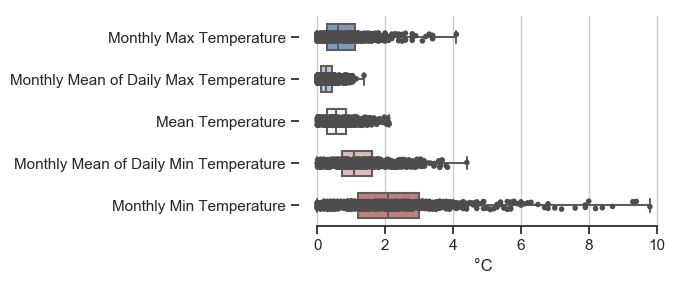

1949-01-01 00:00:00
1949-01-01 00:00:00
1949-01-01 00:00:00
1949-01-01 00:00:00
1949-01-01 00:00:00


In [15]:
features_of_interest = ['MX_TX', 'MO_TX', 'MO_TT', 'MO_TN', 'MX_TN'] # Temperature

df_compare = analyzer.compare_multiple_features(df, features_of_interest)
visualizer.plot_boxplot(df_compare, features_of_interest)

# Check the first date which has a valid value.
for feature in features_of_interest:
    print(analyzer.first_date_with_data(df_compare, feature))

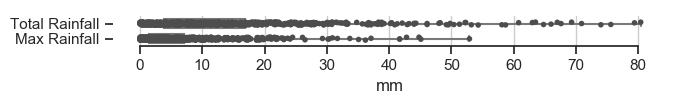

1949-01-01 00:00:00
1949-01-01 00:00:00


In [16]:
features_of_interest = ['MO_RR', 'MX_RS'] # Percipitation

df_compare = analyzer.compare_multiple_features(df, features_of_interest)
visualizer.plot_boxplot(df_compare, features_of_interest)

# Check the first date which has a valid value.
for feature in features_of_interest:
    print(analyzer.first_date_with_data(df_compare, feature))

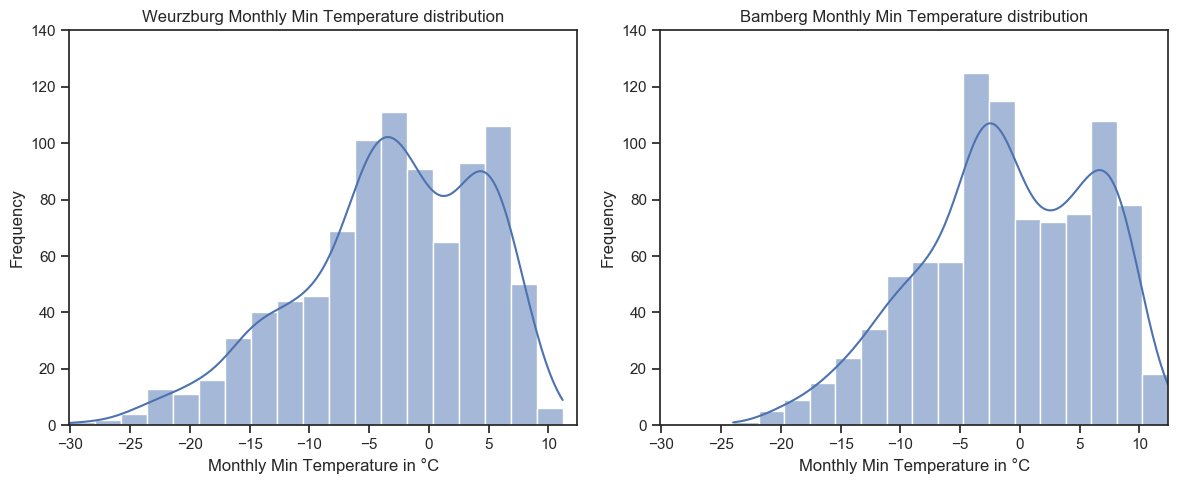

1949-01-01 00:00:00
1947-04-01 00:00:00


<Figure size 640x480 with 0 Axes>

In [17]:
feature_of_interest = 'MX_TN' # Monthly mean temperature

global_xmin = min(Bamberg_df[feature_of_interest].min(),
                  Wuerzburg_df[feature_of_interest].min())
global_xmax = max(Bamberg_df[feature_of_interest].max(),
                  Wuerzburg_df[feature_of_interest].max())

global_ymin = 0
global_ymax = 140

xlim = (global_xmin, global_xmax)
ylim = (global_ymin, global_ymax)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

visualizer.plot_feature_histogram(Bamberg_df, feature_of_interest,
                                  ax=axs[0], xlim=xlim, ylim=ylim)
axs[0].set_title("Weurzburg " + axs[0].get_title())


visualizer.plot_feature_histogram(Wuerzburg_df, feature_of_interest,
                                  ax=axs[1], xlim=xlim, ylim=ylim)
axs[1].set_title("Bamberg " + axs[1].get_title())

plt.tight_layout()
plt.show()

# Check the first date which has a valid value.
print(analyzer.first_date_with_data(Bamberg_df, feature_of_interest))
print(analyzer.first_date_with_data(Wuerzburg_df, feature_of_interest))

plt.clf()

In [22]:
feature_of_interest = 'MX_TN' # Monthly min. of daily temp. min.

def count_rows_below_threshold(df, feature_of_interest, threshold):
    count = df[df[feature_of_interest] < threshold].shape[0]
    return count

Bamberg_freezing_months = count_rows_below_threshold(Bamberg_df, feature_of_interest, 0)
Wuerzburg_freezing_months = count_rows_below_threshold(Wuerzburg_df, feature_of_interest, 0)

Bamberg_percent_freezing_months = Bamberg_freezing_months / Bamberg_df[feature_of_interest].count() * 100
Wuerzburg_percent_freezing_months = Wuerzburg_freezing_months / Wuerzburg_df[feature_of_interest].count() * 100

print(f"Bamberg had {Bamberg_freezing_months} months with a day below freezing, which is {Bamberg_percent_freezing_months}% of its months on record.")
print(f"Wuerzburg had {Wuerzburg_freezing_months} months with a day below freezing, which is {Wuerzburg_percent_freezing_months}% of its months on record.")

Bamberg had 564 months with a day below freezing, which is 62.66666666666667% of its months on record.
Wuerzburg had 515 months with a day below freezing, which is 55.91748099891423% of its months on record.


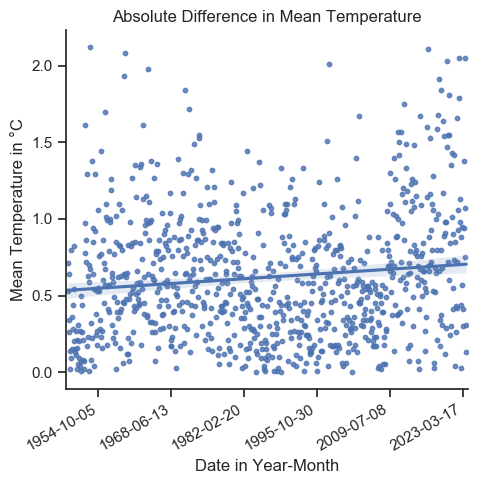

1949-01-01 00:00:00


In [8]:
feature_of_interest = 'MO_TT' # Monthly mean temperature

df_compare = analyzer.compare_features(df, feature_of_interest)
visualizer.plot_feature_regression(df_compare, 'DATE', feature_of_interest)

# Check the first date which has a valid value.
print(analyzer.first_date_with_data(df_compare, feature_of_interest))

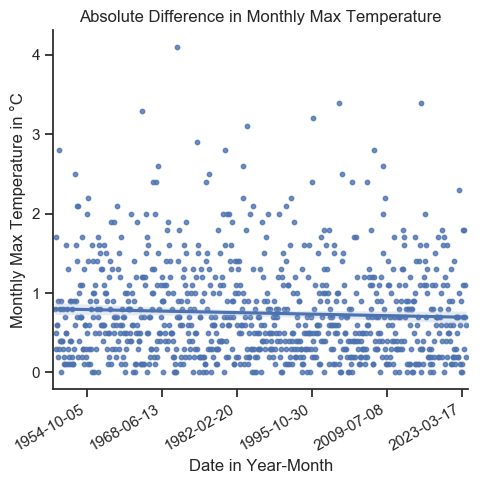

1949-01-01 00:00:00


In [9]:
feature_of_interest = 'MX_TX' # Monthly maximum temperature

df_compare = analyzer.compare_features(df, feature_of_interest)
visualizer.plot_feature_regression(df_compare, 'DATE', feature_of_interest)

# Check the first date which has a valid value.
print(analyzer.first_date_with_data(df_compare, feature_of_interest))

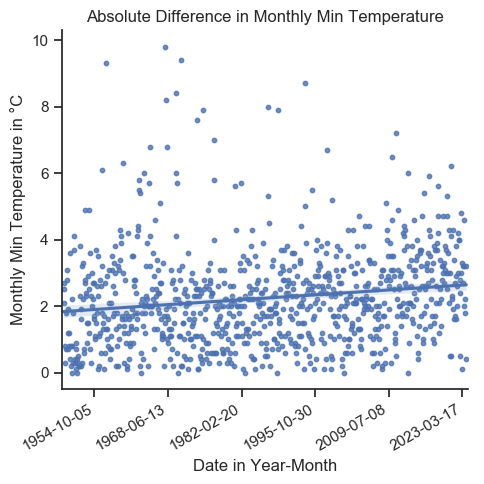

1949-01-01 00:00:00


In [10]:
feature_of_interest = 'MX_TN' # Monthly minimum temperature

df_compare = analyzer.compare_features(df, feature_of_interest)
visualizer.plot_feature_regression(df_compare, 'DATE', feature_of_interest)

# Check the first date which has a valid value.
print(analyzer.first_date_with_data(df_compare, feature_of_interest))

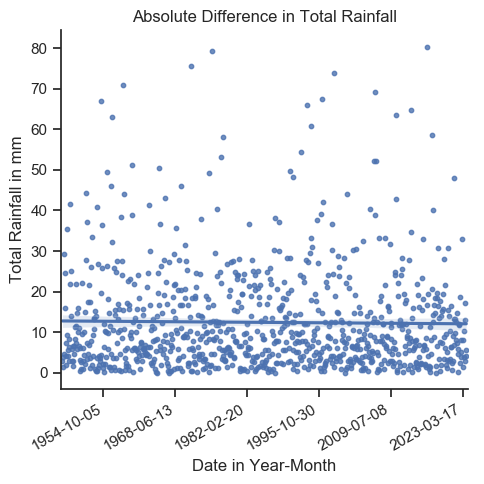

1947-01-01 00:00:00


In [11]:
feature_of_interest = 'MO_RR' # # Monthly percipitation

df_compare = analyzer.compare_features(df, feature_of_interest)
visualizer.plot_feature_regression(df_compare, 'DATE', feature_of_interest)

# Check the first date which has a valid value.
print(analyzer.first_date_with_data(df_compare, feature_of_interest))

In [12]:
# Next up; we'll apply some ML. Stay tuned...
# Let's seperate the STATIONS_ID column and use it as a target
y = df['STATIONS_ID']
X = df.drop(['STATIONS_ID'], axis=1)

X.head()

,DATE,MESS_DATUM_BEGINN,MESS_DATUM_ENDE,QN_4,MO_N,MO_TT,MO_TX,MO_TN,MO_FK,MX_TX,MX_FX,MX_TN,MO_SD_S,QN_6,MO_RR,MX_RS
0,1881-01-01 00:00:00,1881-01-01,1881-01-31,5.0,NaN,NaN,-2.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1881-02-01 00:00:00,1881-02-01,1881-02-28,5.0,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1881-03-01 00:00:00,1881-03-01,1881-03-31,5.0,NaN,NaN,7.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1881-04-01 00:00:00,1881-04-01,1881-04-30,5.0,NaN,NaN,10.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1881-05-01 00:00:00,1881-05-01,1881-05-31,5.0,NaN,NaN,17.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
